<a href="https://colab.research.google.com/github/smahesh2694/NEU_CLS-64/blob/master/xai_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install -q xlrd

In [0]:
 #!git clone https://smahesh2694:@github.com/smahesh2694/NEU_CLS-64.git

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam,SGD


In [0]:
base_model=MobileNet(weights='imagenet',include_top=False, input_shape= (200, 200, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '







17227776/17225924 [==============================] - 0s 0us/step


In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x)
#x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(6,activation='softmax')(x)

In [0]:
model=Model(inputs=base_model.input, outputs=preds)

In [0]:
base_model.trainable = False #default

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 validation_split=0.2)

In [0]:
bs = 16

In [0]:
train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database',  #NEU-CLS-64
                                                 target_size=(200,200),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training')

Found 1447 images belonging to 6 classes.


In [0]:
label_map = (train_generator.class_indices)
print(label_map)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}


In [0]:
val_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database', 
                                                 target_size=(200,200),  
                                                 #batch_size=32,                                                                                                batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 361 images belonging to 6 classes.


In [0]:
sgd = SGD(lr=0.01, clipvalue=0.5)
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [0]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)
step_size_val=val_generator.n//val_generator.batch_size
print(step_size_val)

90
11


In [0]:
initial_epochs = 25

In [0]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

In [0]:
#print(history.history.keys())

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

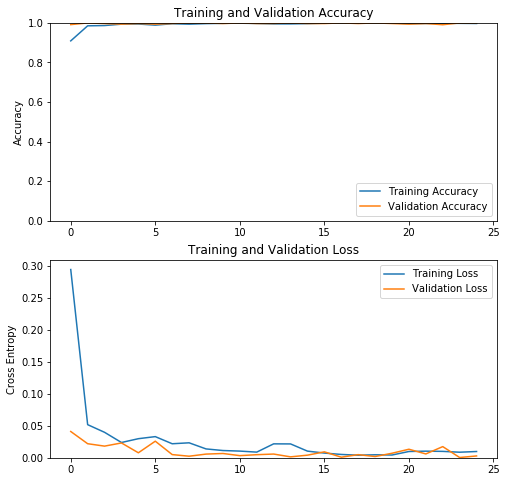

In [0]:
*plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.savefig('/content/drive/My Drive/xai_model/MN_80_20_SGD_21.jpg')
plt.show()



In [0]:
base_model.trainable = True

In [0]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  87


In [0]:
fine_tune_at = 61

In [0]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
#model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [0]:
#model.summary()

In [0]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 26/40
90/90 [==============================] - 26s 293ms/step - loss: 0.0067 - acc: 0.9986 - val_loss: 0.0128 - val_acc: 0.9943
Epoch 27/40
90/90 [==============================] - 27s 300ms/step - loss: 0.0084 - acc: 0.9972 - val_loss: 0.0052 - val_acc: 0.9970
Epoch 28/40
90/90 [==============================] - 26s 289ms/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0059 - val_acc: 0.9970
Epoch 29/40
90/90 [==============================] - 26s 285ms/step - loss: 0.0065 - acc: 0.9986 - val_loss: 0.0050 - val_acc: 0.9970
Epoch 30/40
90/90 [==============================] - 27s 296ms/step - loss: 0.0054 - acc: 0.9979 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 31/40
90/90 [==============================] - 25s 277ms/step - loss: 0.0064 - acc: 0.9979 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 32/40
90/90 [==============================] - 25s 274ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0031 - val_acc: 0.9970
Epoch 33/40
90/90 [==============================] - 24s 267ms

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

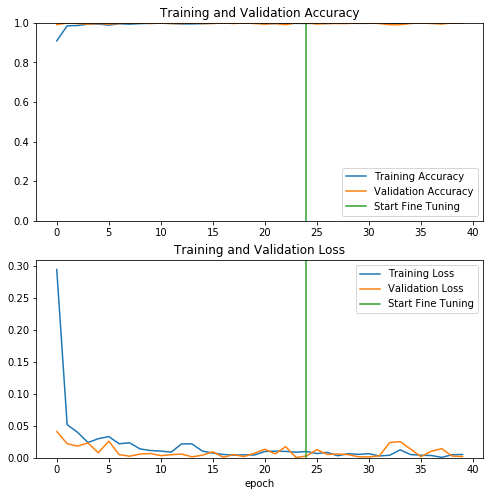

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('/content/drive/My Drive/xai_model/MN_FT_80_20_SFD_21.jpg')
plt.show()

In [0]:
model.save('/content/drive/My Drive/xai_model/model.h5')

In [0]:
#model.save_weights('/content/drive/My Drive/xai_model/weights.h5')

Prediction on model 20

In [0]:
#saved_model = load_model('/content/drive/My Drive/xai_model/model.h5')

In [0]:
#saved_model.layers[0].input_shape

In [0]:
#saved_model.summary()

In [0]:
#model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])

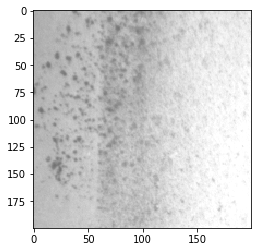

In [0]:
image_path="/content/drive/My Drive/xai_model/PS_92.bmp"
img = image.load_img(image_path, target_size=(200,200))
plt.imshow(img)

In [0]:
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = model.predict(img)
print(result)

[[3.9846003e-03 2.3269234e-07 9.9086517e-01 3.1296597e-03 2.0099618e-03
  1.0327955e-05]]


In [0]:
prediction = result.argmax(axis=-1)
print(label_map)
print(prediction)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}
[2]


In [0]:
if prediction == 0:
  label = "Crazing" 
elif prediction == 1:
  label = "Inclusion"
elif prediction == 2:
  label = "Pitted Surface"
elif prediction == 3:
  label = "Patches"
elif prediction == 4:
  label = "Rolled-in scale"
elif prediction == 5:
  label = "Sratches"
else:
  label = "Exception"

print(label)

Pitted Surface
